# SAM Notebook for Mask Generation Based Off of a Bounding Box
About: Created to generate a segmentation mask using Segment Anything (https://segment-anything.com/) prompted by bounding boxe
<br> This notebook:


1.   Creates bounding boxes (one per img) for a list of input images interactively using OpenCV
2.   Runs Segmentation for the bounding box

<br> This is to be used as a preprocessing step for object reconstruction using nvdiffrc where a binary mask is required in the alpha channel

## Environment Set Up
For colab notebook - run to install required libraries,
Set runtime to GPU

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
import torch
import torchvision
import os

In [2]:
""" print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth """

' print("PyTorch version:", torch.__version__)\nprint("Torchvision version:", torchvision.__version__)\n!{sys.executable} -m pip install opencv-python matplotlib\n!{sys.executable} -m pip install \'git+https://github.com/facebookresearch/segment-anything.git\'\n\n!mkdir images\n!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg\n\n!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth '

### Load Images and SAM Model

In [3]:
# Set up SAM
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"  
model_type = "vit_h"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

Using device: mps


In [19]:
# Input Images
from matplotlib.widgets import RectangleSelector
from IPython.display import clear_output

image_folder = "output_frames"  # Upload images here from frame extraction script
box_save_path = "bboxes.npy"  # output file for bboxes
mask_folder = "masks/"
os.makedirs(mask_folder, exist_ok=True)

image_files = sorted([
    f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png"))
])

## Interactve Bounding Box Drawing
This function will allow drawing a bounding box with a mouse using open cv for the object that will be automatically segmented - alternatively can use clicking functionality like in META demo:

In [5]:
def get_bbox(image, window_name="Draw Bounding Box"):
    """
    Draw a single bounding box on an image.
    Controls:
    - ENTER/SPACE = confirm box
    - ESC         = skip image
    - BACKSPACE   = go back to previous image
    - Q           = quit the entire loop
    """
    PADDING = 30
    image_padded = cv2.copyMakeBorder(
        image,
        top=PADDING,
        bottom=PADDING,
        left=PADDING,
        right=PADDING,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]  # white
    )
    height, width = image.shape[:2]
    
    clone = image_padded.copy()
    box = []
    dragging = False
    cursor = (0, 0)
    
    def clamp_point(pt):
        x, y = pt
        # Clamp inside padded image bounds
        x = max(0, min(x, width + 2 * PADDING))
        y = max(0, min(y, height + 2 * PADDING))
        return (x, y)
        
    def mouse_callback(event, x, y, flags, param):
        nonlocal box, dragging, cursor
        cursor = (x, y)

        if event == cv2.EVENT_LBUTTONDOWN:
            box = [(x, y)]
            dragging = True

        elif event == cv2.EVENT_MOUSEMOVE and dragging:
            box = [box[0], (x, y)]

        elif event == cv2.EVENT_LBUTTONUP:
            box.append((x, y))
            dragging = False

    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, mouse_callback)

    while True:
        frame = clone.copy()

        # Draw crosshair
        cx, cy = cursor
        cv2.line(frame, (cx, 0), (cx, frame.shape[0]), (0, 255, 0), 1)
        cv2.line(frame, (0, cy), (frame.shape[1], cy), (0, 255, 0), 1)

        # Draw bounding box
        if len(box) >= 2:
            x1, y1 = box[0]
            x2, y2 = box[1]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Overlay instructions
        cv2.putText(frame, "ENTER/SPACE=confirm | ESC=skip | BACKSPACE=go back | Q=quit",
                    (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)

        cv2.imshow(window_name, frame)
        key = cv2.waitKey(10)

        if key in [13, 32]:  # ENTER or SPACE
            if len(box) >= 2:
                x1, y1 = box[0]
                x2, y2 = box[1]

                # Clamp box coordinates back inside original image bounds
                x_min = max(0, min(x1, x2) - PADDING)
                y_min = max(0, min(y1, y2) - PADDING)
                x_max = min(width, max(x1, x2) - PADDING)
                y_max = min(height, max(y1, y2) - PADDING)
                
                cv2.destroyAllWindows()
                return [x_min, y_min, x_max, y_max]

        elif key == 27:  # ESC
            cv2.destroyAllWindows()
            return None

        elif key == ord('q'):  # Quit all
            cv2.destroyAllWindows()
            return "quit"

        elif key in [8, 127]:  # BACKSPACE 
            cv2.destroyAllWindows()
            return "back"


Iterate through images and save - draw box when the window opens up then press a key to save

In [ ]:
bboxes = {}
history = []

i = 0
while i < len(image_files):
    fname = image_files[i]
    img_path = os.path.join(image_folder, fname)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Could not load {fname}")
        i += 1
        continue

    result = get_bbox(image, window_name=f"Draw box for {fname}")

    if result == "quit":
        print("Stopped by user.")
        break

    elif result == "back":
        if history:
            last_fname = history.pop()
            bboxes.pop(last_fname, None)
            i -= 1  # go back
            print(f"Going back to {image_files[i]}")
        else:
            print("No hist")
        continue

    elif result is None:
        print(f"Skipped {fname}")
        i += 1
        continue

    else:
        bboxes[fname] = result
        history.append(fname)
        np.save(box_save_path, bboxes) #save
        print(f"Saved box for {fname}")
        i += 1


## Run SAM Map Prediction Based off of Bounding Boxes


In [24]:
for fname, box in bboxes.items():
    img_path = os.path.join(image_folder, fname)
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_rgb)
    input_box = np.array(box)
    masks, scores, logits = predictor.predict(
        box=input_box[None, :],
        multimask_output=True
    )
    
    merged_mask = merged_mask = (np.any(masks, axis=0).astype(np.uint8)) * 255 # Composite mask

    # Fill small holes and remove speckles
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(merged_mask, cv2.MORPH_CLOSE, kernel)  # fill holes
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)        # remove noise

    save_path = os.path.join(mask_folder, fname.replace(".jpg", ".png"))
    cv2.imwrite(save_path, opened)
    

Display Mask for Debbugging

In [41]:
def show_mask_overlay(image, mask, alpha=0.5):
    # Convert to grayscale
    if mask.ndim == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # Convert mask to boolean where white pixels are True
    if mask.max() > 1:
        mask = (mask == 255)
    else:
        mask = (mask == 1)
    
    pink = np.array([1.0, 165/255.0, 0.0])  # RGB values normalized to 0-1
    
    # Normalize image to 0-1 float if needed
    if image.max() > 1:
        overlay = image / 255.0
    else:
        overlay = image.copy().astype(np.float32)
    
    # Blend pink only on the white mask pixels
    blended = overlay.copy()
    for c in range(3):
        blended[..., c] = np.where(
            mask,
            (1 - alpha) * overlay[..., c] + alpha * pink[c],
            overlay[..., c]
        )
    
    plt.figure(figsize=(8, 8))
    plt.imshow(blended)
    plt.axis('off')
    plt.show()

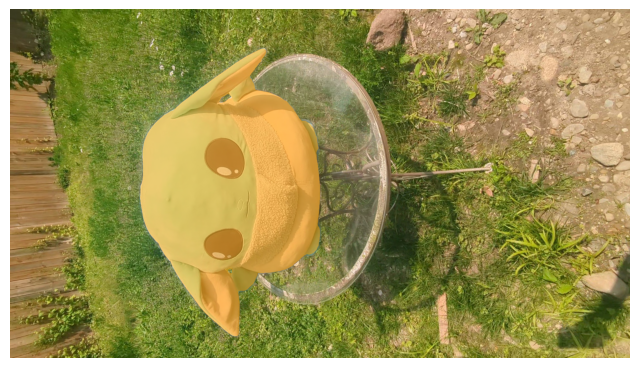

In [45]:
img_path = os.path.join(image_folder, "frame_0111.jpg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_path = os.path.join(mask_folder, "frame_0111.png")
mask = cv2.imread(mask_path)
show_mask_overlay(img, mask)